In [59]:
import pm4py
import plotly.graph_objects as go
import ast
import pandas as pd
from Road_traffic_module import *
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from collections import defaultdict

# 0 Load the enriched case log

In [60]:
INPUT_FILE_NAME = 'cases_rtfm_full.csv' # the enriched event log
CASE_ID_COL = 'case:concept:name'
TIMESTAMP_COL = 'time:timestamp'
ACTIVITY_COL = 'concept:name'

In [61]:
# read the enriched case log csv into a dataframe
df = pd.read_csv(INPUT_FILE_NAME,  dtype={'org:resource': str, 'matricola': str})
print(len(df), 'rows read from', INPUT_FILE_NAME)

# df.info()
df.head()

C:\Users\Timot\AppData\Local\Temp\ipykernel_53076\1999305717.py:2: DtypeWarning: Columns (45,46,47,51,59,63,70,74,94,99,106,110,117,118,122,129,133,140,144,152,153,158,165,170,177,182,189,194,201,206,213,218,225,230,237,242,249,254,261,266,273,278,285,290,297,302,309,314) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_FILE_NAME,  dtype={'org:resource': str, 'matricola': str})


150370 rows read from cases_rtfm_full.csv


,case_id,Create Fine.count,event_count,start_time,start_time_rel,duration,Create Fine.start,Create Fine.amount,Create Fine.org:resource,Create Fine.dismissal,...,Payment:Create Fine.delay,paid_full,dismissed,credit_collection,unresolved,appeal,overturned_judge,overturned_prefecture,overturned,upheld
0,S38735,1,5,2000-01-01,0,830,0,62.59,18,NIL,...,NaN,False,False,True,False,False,False,False,False,False
1,S44306,1,5,2000-01-02,1,464,0,62.59,704,NIL,...,NaN,False,False,True,False,False,False,False,False,False
2,S49055,1,6,2000-01-02,1,239,0,31.30,35,NIL,...,-104.0,False,False,False,True,False,False,False,False,False
3,S49056,1,5,2000-01-02,1,829,0,31.30,35,NIL,...,NaN,False,False,True,False,False,False,False,False,False
4,S49057,1,5,2000-01-02,1,829,0,31.30,35,NIL,...,NaN,False,False,True,False,False,False,False,False,False


# 1 Visualize the Outcome Distribution

In [108]:
#define the list of predicates
lst_of_predicates = [(lambda row: row["Final.outstanding_balance"] <= 0.0), # predicate for Fully Paid
                      (lambda row: row["Send for Credit Collection.count"] >= 1), # predicate for Collected
                      (lambda row: row["Final.dismissal::last"] in ['G', '#']) # predicate for Dismissed
                    ]
#define the labels of the outcomes
outcomes_labels = ["Fully Paid", "Collected", "Dismissed"]

In [63]:
df_outcome = df.copy()
filtered_dataframes = []
overlap_check = []
values = []

for i in range(len(outcomes_labels)):
    df_outcome[outcomes_labels[i]] = df_outcome.apply(lst_of_predicates[i], axis=1)
    filtered_dataframes.append(df_outcome.loc[df_outcome[outcomes_labels[i]] == True, ['case_id']])
    values.append([len(filtered_dataframes[i])])

for l in range(len(filtered_dataframes)):
    if l == 0:
        unresolved = df_outcome.loc[~df_outcome['case_id'].isin(filtered_dataframes[l]['case_id']), ['case_id']]
    else:
        unresolved = unresolved.loc[~unresolved['case_id'].isin(filtered_dataframes[l]['case_id']), ['case_id']]

dct = defaultdict(list)

# Loop over the list and append the combinations to the dictionary
for i in range(len(outcomes_labels)):
    for j in range(i+1, len(outcomes_labels)):
        dct[outcomes_labels[i]].append(outcomes_labels[j])
        overlap_check.append(len(pd.merge(filtered_dataframes[i], filtered_dataframes[j], how='inner', on=['case_id'])))
# Convert the defaultdict to a regular dict
dct = dict(dct)
k = 0 # index for values
for key, value in dct.items():
    
    for i in range(len(value)):
        
        value[i] = (value[i], overlap_check[k]) # make a tuple of string and value
        k += 1 # increment index
print(dct)
values.append([len(unresolved)])

{'Fully Paid': [('Collected', 3), ('Dismissed', 1)], 'Collected': [('Dismissed', 0)]}


In [116]:
for i in dct["Collected"]:
    print(i[1])

0


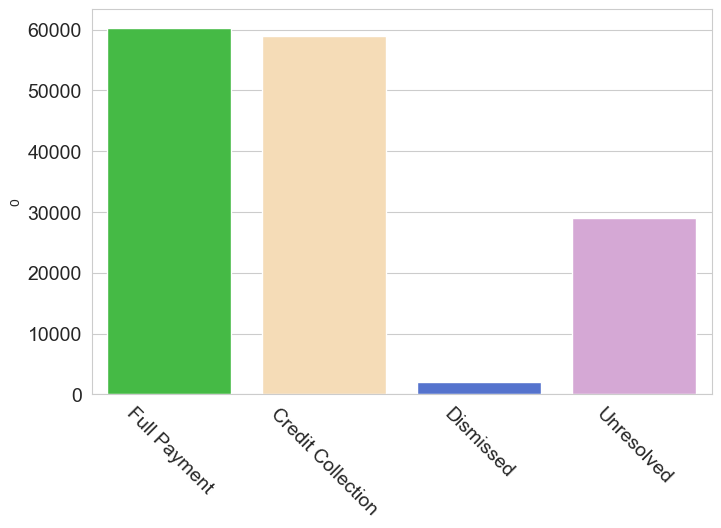

In [103]:
#Create a dictionary with the colors for each variable
colors = {"Full Payment": "limegreen", "Dismissed": "royalblue", "Credit Collection": "navajowhite", "Unresolved": "plum"}
# Create a pandas DataFrame with your data
data = {"Full Payment": [values[0][0] -4],  "Credit Collection": [values[1][0] -3], "Dismissed": [values[2][0] -1], "Unresolved": [values[3][0]]}
df_bar = pd.DataFrame(data)
# Create the bar chart
plt.figure(figsize=(8, 5))
sns.barplot(y = df_bar.iloc[0], x=df_bar.columns, palette=colors)
# Set the background color
sns.set_style("whitegrid")
# change font size of y axis and x axis
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(rotation=-45)
plt.show()

In [106]:
def outcome_visualization(df, outcomes_labels, lst_of_predicates):
    values = []
    labels = []
    filtered_dataframes = []
    overlap_check = []
    for i in range(len(outcomes_labels)):
        
        df[outcomes_labels[i]] = df.apply(lst_of_predicates[i], axis=1)
        filtered_dataframes.append(df.loc[df[outcomes_labels[i]] == True, ['case_id']])

        
        values.append([len(filtered_dataframes[i])])
    #print(values)
    # we create an additional dataframe called unresolved which is the difference between all the filtered dataframes combined and the input dataframe
    #unresolved = df.loc[~df['case_id'].isin(filtered_dataframes[0]['case_id']) & ~df['case_id'].isin(filtered_dataframes[1]['case_id']), ['case_id']]
    for l in range(len(filtered_dataframes)):
        if l == 0:
            unresolved = df.loc[~df['case_id'].isin(filtered_dataframes[l]['case_id']), ['case_id']]
        else:
            unresolved = unresolved.loc[~unresolved['case_id'].isin(filtered_dataframes[l]['case_id']), ['case_id']]
    
    #print(len(unresolved))
    #print(len(df))



    # we check the overlap between the outcomes
    # Create an empty defaultdict with list as default value
    dct = defaultdict(list)

    # Loop over the list and append the combinations to the dictionary
    for i in range(len(outcomes_labels)):
        for j in range(i+1, len(outcomes_labels)):
            dct[outcomes_labels[i]].append(outcomes_labels[j])
            overlap_check.append(len(pd.merge(filtered_dataframes[i], filtered_dataframes[j], how='inner', on=['case_id'])))

    # Convert the defaultdict to a regular dict
    dct = dict(dct)
    k = 0 # index for values
    for key, value in dct.items():
        
        for i in range(len(value)):
            
            value[i] = (value[i], overlap_check[k]) # make a tuple of string and value
            k += 1 # increment index
    print(dct)

    # visualize the outcomes
    # create the dictionary for the colours
    outcomes_labels.append("unresolved")
    colours = ["limegreen", "royalblue", "navajowhite", "plum", "crimson", "moccasin", "gold", "cyan"]
    colour_dict = dict(zip(outcomes_labels, colours))
    values.append([len(unresolved)])
    output_dict = dict(zip(outcomes_labels, values))
    df_bar = pd.DataFrame(output_dict)
    plt.figure(figsize=(8, 5))
    # Create the bar chart
    #print(f" this is the df_bar: {df_bar}")

    sns.barplot(y = df_bar.iloc[0], x=df_bar.columns, palette=colour_dict,)
    #sns.set_style("whitegrid")
    plt.yticks(fontsize=11)
    plt.xticks(fontsize=11)


    #output_dict = dict(zip(outcomes_labels, values))
    print(output_dict)
    print(f"Total number of cases: {len(df)}")

    return plt.show()

In [20]:
print(f"paid full: {len(df[df['paid_full'] == True])}")
print(f"dismissed: {len(df[df['dismissed'] == True])}")
print(f" credit collected: {len(df[df['credit_collection'] == True])}")
print(f"unresolved: {len(df[df['unresolved'] == True])}")

paid full: 60290
dismissed: 2061
 credit collected: 59013
unresolved: 29010


-4 from paid and -3 from collected and -1 from dismissed

In [40]:
df_outcome = df.copy()

{'Fully Paid': [('Collected', 3), ('Dismissed', 1)], 'Collected': [('Dismissed', 0)]}
{'Fully Paid': [60290], 'Collected': [59013], 'Dismissed': [2061], 'unresolved': [29010]}
Total number of cases: 150370


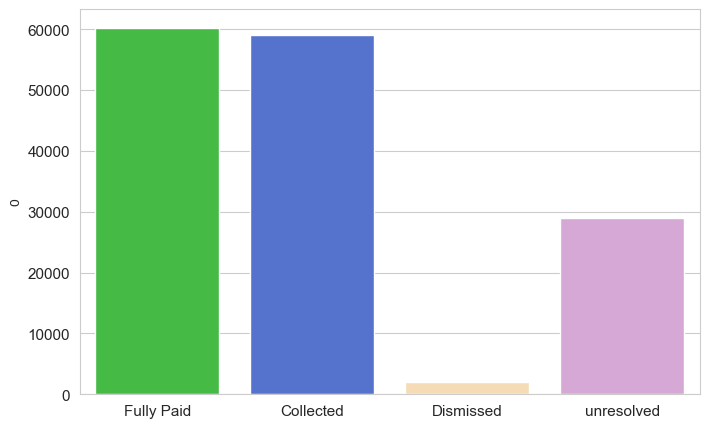

In [109]:
outcome_visualization(df_outcome, outcomes_labels, lst_of_predicates)